<a href="https://colab.research.google.com/github/priyangshu-datta/independent-study/blob/main/water%20quality%20prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install shap xgboost strenum

# Imports

In [ ]:
import enum
import itertools as it
import pickle
import typing
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
import strenum
import tqdm
import xgboost
from sklearn import (
    base,
    ensemble,
    feature_selection,
    metrics,
    model_selection,
    neighbors,
    preprocessing,
    svm,
)

# Configuration

In [ ]:
class Models(strenum.StrEnum):
    SVM = enum.auto()
    XGB = enum.auto()
    RF = enum.auto()
    GB = enum.auto()
    AB = enum.auto()


class Rivers(strenum.StrEnum):
    BEAS = enum.auto()
    BRAHMAPUTRA = enum.auto()
    CAUVERY = enum.auto()
    GANGA = enum.auto()
    GODAVARI = enum.auto()
    KRISHNA = enum.auto()
    MAHANADI = enum.auto()
    SATLUJ = enum.auto()
    YAMUNA = enum.auto()


class Parameters(strenum.StrEnum):
    TEMP = "Temperature"
    DO = "Dissolved Oxygen"
    PH = "pH"
    COND = "Conductivity"
    BOD = "Biochemical Oxygen Demand"
    NC = "Nitrate Nitrite Conc"
    FC = "Fecal Coliform"
    TC = "Total Coliform"


long_keys = [lk.value for lk in Parameters]
short_keys = [lk.name for lk in Parameters]

short2long = {k: v for k, v in zip(short_keys, long_keys)}
long2short = {v: k for k, v in short2long.items()}

model_params: dict[
    Models,
    dict[
        typing.Literal["fixed", "tuning", "other"],
        dict[str, str | int | float | bool | list],
    ],
] = {
    Models.AB: {
        "fixed": {
            "loss": "square",
            "random_state": 0,
        },
        "tuning": {
            "n_estimators": [1000, 3000, 4500],
            "learning_rate": [0.001, 0.01, 0.1],
        },
        "other": {},
    },
    Models.GB: {
        "fixed": {
            "loss": "squared_error",
            "random_state": 0,
            "max_depth": 10,
            "subsample": 0.5,
        },
        "tuning": {
            "n_estimators": [1000, 3000, 4500],
            "learning_rate": [0.01, 0.001, 0.1],
        },
        "other": {},
    },
    Models.RF: {
        "fixed": {
            "max_depth": 10,
            "random_state": 0,
            "max_samples": 0.5,
            "criterion": "squared_error",
        },
        "tuning": {
            "n_estimators": [1000, 3000, 5000],
        },
        "other": {},
    },
    Models.XGB: {
        "fixed": {
            "random_state": 0,
            "subsample": 0.5,
        },
        "tuning": {
            "n_estimators": [5000, 7500, 10000, 15000, 20000],
            "learning_rate": [0.01, 0.1, 0.001],
        },
        "other": {
            "early_stopping_rounds": 50,
            "eval_metric": metrics.mean_squared_error,
        },
    },
    Models.SVM: {"fixed": {}, "tuning": {}, "other": {}},
}

estimators: dict[
    Models,
    type[ensemble.GradientBoostingRegressor]
    | type[ensemble.RandomForestRegressor]
    | type[svm.SVR]
    | type[xgboost.XGBRegressor]
    | type[ensemble.AdaBoostRegressor]
] = {
    Models.GB: ensemble.GradientBoostingRegressor,
    Models.RF: ensemble.RandomForestRegressor,
    Models.SVM: svm.SVR,
    Models.XGB: xgboost.XGBRegressor,
    Models.AB: ensemble.AdaBoostRegressor
}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
root_path = Path("./drive/MyDrive/Water Quality Prediction (Independent Study)/")
all_paths = {
    "model": root_path.joinpath("models"),
    "image": root_path.joinpath("images"),
    "best_param": root_path.joinpath("best_params"),
    "shap_value": root_path.joinpath("shap_values"),
    "data": root_path.joinpath("."),
}
for path in all_paths.values():
    path.mkdir(exist_ok=True, parents=True)

# Utils

In [ ]:
T = typing.TypeVar("T")

In [ ]:
def remove_outliers(data: pd.Series) -> list[int]:
    mu = data.mean()
    sigma = data.std()
    outliers_index = [
        i for i, x in enumerate(data) if x > (mu + 4 * sigma) or x < (mu - 4 * sigma)
    ]

    return outliers_index

In [ ]:
def read_pkl(pkl_path: Path):
    with open(pkl_path, "rb") as pkl:
        return pickle.load(pkl)


def write_pkl(python_obj: any, pkl_path: Path):
    assert pkl_path.suffix == ".pkl", "Path does not point to a .pkl file."
    pkl_path.parent.mkdir(exist_ok=True, parents=True)

    with open(pkl_path, "wb") as pkl:
        return pickle.dump(python_obj, pkl, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
def file_exists(
    file_path_s: Path | list[Path] | typing.Iterator[Path],
) -> dict[typing.Literal["exists", "not_exists"], typing.List[Path]]:
    exists = []
    not_exists = []
    if isinstance(file_path_s, Path):
        return (
            {"exists": [file_path_s], "not_exists": []}
            if file_path_s.exists()
            else {"exists": [], "not_exists": [file_path_s]}
        )
        # return ([file_path_s], []) if file_path_s.exists() else ([], [file_path_s])
    for f_path in file_path_s:
        if f_path.exists():
            exists.append(f_path)
        else:
            not_exists.append(f_path)
    return {"exists": exists, "not_exists": not_exists}

In [ ]:
dir(enum)

['DynamicClassAttribute',
 'Enum',
 'EnumMeta',
 'Flag',
 'IntEnum',
 'IntFlag',
 'MappingProxyType',
 '_EnumDict',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_auto_null',
 '_decompose',
 '_high_bit',
 '_is_descriptor',
 '_is_dunder',
 '_is_private',
 '_is_sunder',
 '_make_class_unpicklable',
 '_reduce_ex_by_name',
 'auto',
 'sys',
 'unique']

In [ ]:
def literal_to_list(abc: T | list[T]) -> typing.List[T]:
    if not (isinstance([] if abc is None else abc, enum.Enum) or isinstance(abc, list)):
        return [abc]
    return abc

In [ ]:
def concat_dicts(*args: dict[str, any]):
    return {k: v for k, v in it.chain(*[d.items() for d in args])}

In [ ]:
def prettylog(prefix: str):
    return lambda x: print(f"[{prefix}]: {x}")

# Data Preparation

In [ ]:
data_path = all_paths["data"].joinpath("WQ 2012_2021.csv")

## Train Split

In [ ]:
train_df = (
    pd.read_csv(data_path)
    .query("YEAR != 2021")
    .dropna()
    .filter(axis=1, like="AVG")
    .reset_index(drop=True)
)
train_df.columns = long_keys

outliers = []
for col in train_df.columns:
    outliers.extend(remove_outliers(train_df[col]))
train_df = train_df.drop(outliers).reset_index(drop=True)

train_df[long_keys] = preprocessing.MinMaxScaler().fit_transform(train_df)

## Test Split

In [ ]:
test_df = (
    pd.read_csv(data_path)
    .dropna()
    .query("YEAR == 2021")
    .drop(columns=["CODE", "LOCATION", "YEAR"])
    .groupby(["RIVER", "STATE"])
    .mean()
    .filter(axis=1, like="AVG")
    # .reset_index(drop=True)
)
test_df.columns = long_keys
test_df[long_keys] = preprocessing.MinMaxScaler().fit_transform(test_df)

## Data fetch API

In [ ]:
def get_train_data(
    df: pd.DataFrame,
    target: Parameters,
    validation_split: None | float | int = None,
    exclude_features: None | Parameters | list[Parameters] = None,
):
    exclude_features = literal_to_list(exclude_features)

    X = df.drop(columns=[target, *exclude_features])
    y = df[target]

    if validation_split:
        assert 0 < validation_split < 1 or (
            isinstance(validation_split, int) and 0 < validation_split < 100
        ), "validation split must be between 0..1 or 0..100."
        return model_selection.train_test_split(
            X, y, test_size=validation_split, random_state=0
        )
    return X, y

In [ ]:
def get_test_data(
    df: pd.DataFrame,
    target: Parameters,
    exclude_features: None | Parameters | list[Parameters] = None,
):
    exclude_features = literal_to_list(exclude_features)

    X = df.drop(columns=[target, *exclude_features])
    y = df[target]
    return X, y

# Flags

In [ ]:
OVERWRITE = {
    "best_params": False,
    "train_model": False,
    "img_generate": True,
    "shap_calculation": False,
}
# overwrite, ignoring and overwriting all cache.

# Model

## Finetuning Hyperparameters

In [ ]:
def get_fineduned_hyperparams(
    model_name: Models,
    estimator: base.BaseEstimator,
    hyperparam: dict[str, typing.Any],
    sample_percent: float,
    train_df: pd.DataFrame,
    targets: Parameters | list[Parameters],
    exclude_features: None | Parameters | list[Parameters],
    path_prefix: Path = "",
) -> dict[Models, dict]:
    log = prettylog("Hyperparameter tuning")
    exclude_features = literal_to_list(exclude_features)
    targets = literal_to_list(targets)

    if hyperparam.items().__len__() < 1:
        return {}.fromkeys(long_keys, {})

    best_model_params: dict[Models, dict] = {}

    processed = []
    if not OVERWRITE["best_params"]:
        log("Reading from cache...")
        for target in targets:
            best_param_PATH = all_paths["best_param"].joinpath(
                path_prefix, model_name, f"{target}.pkl"
            )
            if file_exists(best_param_PATH)["exists"].__len__() < 1:
                continue
            best_model_params[target] = read_pkl(best_param_PATH)
            processed.append(target)

    remaining_targets = list(set(targets).difference(processed))
    print(targets)
    if remaining_targets.__len__() < 1:
        return best_model_params

    hp_tuner = model_selection.GridSearchCV(
        estimator=estimator, cv=5, n_jobs=5, verbose=0, param_grid=hyperparam
    )

    param_find_df = train_df.sample(frac=sample_percent).reset_index(drop=True)
    num_targets = len(remaining_targets)
    for index, target in (
        pbar := tqdm.tqdm(
            enumerate(remaining_targets),
            desc="Fine-tuing for",
            bar_format="{desc}",
        )
    ):
        pbar.set_description_str(
            f"Fine-tuning for {target}. Completed: ({index}/{num_targets})."
        )

        hp_tuner.fit(
            param_find_df.drop(columns=[target, *exclude_features]),
            param_find_df[target],
        )
        best_model_params[target] = hp_tuner.best_params_
        write_pkl(
            python_obj=hp_tuner.best_params_,
            pkl_path=Path(
                all_paths["best_param"].joinpath(
                    path_prefix or "", model_name, f"{target}.pkl"
                ),
            ),
        )

        pbar.set_description_str(
            f"Fine-tuning for {target}. Completed: ({index+1}/{num_targets})."
        )

    return best_model_params

## to and from disk

In [ ]:
def save_models(
    models_collection: dict[Models, dict[Parameters, base.BaseEstimator]],
    path_prefix: Path = "",
):
    for model_name, models_dict in models_collection.items():
        for target, model in models_dict.items():
            write_pkl(
                model,
                all_paths["model"]
                .joinpath(path_prefix, model_name, target)
                .with_suffix(".pkl"),
            )


def load_models(
    model_name: Models, targets: Parameters | list[Parameters], path_prefix: Path
):
    models: dict[Parameters, base.BaseEstimator] = {}
    targets = literal_to_list(targets)
    for target in targets:
        models[target] = read_pkl(
            pkl_path=all_paths["model"]
            .joinpath(path_prefix, model_name, target)
            .with_suffix(".pkl")
        )

    return models

## Train a single Model

In [ ]:
def train(
    model_name: Models,
    targets: Parameters | list[Parameters],
    sample_percent: float,
    path_prefix: str,
    exclude_features: None | Parameters | list[Parameters] = None,
):
    log = prettylog("Training")
    models = {}

    exclude_features = literal_to_list(exclude_features)
    targets = literal_to_list(targets)

    if not OVERWRITE["train_model"]:
        cached_models_path, targets = file_exists(
            [
                all_paths["model"]
                .joinpath(path_prefix or "", model_name, target)
                .with_suffix(".pkl")
                for target in targets
            ]
        ).values()

        cached_models_path = [path.stem for path in cached_models_path]
        targets = [
            path.stem for path in targets if exclude_features.count(path.stem) < 1
        ]
        log("Reading from Cache...")
        models = load_models(model_name, cached_models_path, path_prefix)

    if models.__len__() > 0:
        return models

    assert 0 <= sample_percent <= 1, "Sample percent must be in 0..1"

    print(f"Training {model_name}")
    est = estimators[model_name]

    finetuned = get_fineduned_hyperparams(
        model_name=model_name,
        estimator=est(**model_params[model_name]["fixed"]),
        hyperparam=model_params[model_name]["tuning"],
        sample_percent=sample_percent,
        train_df=train_df,
        targets=targets,
        exclude_features=exclude_features,
        path_prefix=path_prefix,
    )

    full_model_params = {}
    for target, finetuned_hp in finetuned.items():
        full_model_params[target] = concat_dicts(
            model_params[model_name]["fixed"],
            finetuned_hp,
            model_params[model_name]["other"],
        )

    num_targets = full_model_params.keys().__len__()
    for index, (target, parameters) in (
        pbar := tqdm.tqdm(
            enumerate(full_model_params.items()),
            desc="",
            bar_format="{desc}",
        )
    ):
        pbar.set_description_str(
            f"Training for {target}. Progress: {index + 1}/{num_targets}"
        )

        reg = est(**parameters)

        if model_name == Models.XGB:
            X_train, X_eval, y_train, y_eval = get_train_data(
                df=train_df,
                target=target,
                validation_split=0.2,
                exclude_features=exclude_features,
            )
            reg.fit(X_train, y_train, eval_set=[(X_eval, y_eval)], verbose=0)
        else:
            X_train, y_train = get_train_data(
                df=train_df, target=target, exclude_features=exclude_features
            )
            reg.fit(X_train, y_train)

        models[target] = reg

    return models

## Train multiple Models

In [ ]:
def train_models(
    exclude_features: None | Parameters | list[Parameters],
    include_models: tuple[bool, Models | list[Models]],
    sample_percent: float = 1,
    path_prefix: None | Path = None,
):
    if include_models[0]:
        model_names = set(literal_to_list(include_models[1]))
    else:
        model_names = set(Models).difference(set(literal_to_list(include_models[1])))

    exclude_features = literal_to_list(exclude_features)
    models = {}

    for model_name in model_names:
        models[model_name] = train(
            model_name,
            targets=list(set(Parameters) - set(exclude_features)),
            sample_percent=sample_percent,
            exclude_features=exclude_features,
            path_prefix=path_prefix,
        )

    if path_prefix:
        save_models(models, path_prefix)

## Train Model(s)

In [ ]:
exclude_features = [Parameters.FC]
path_prefix = f"{'exclude_features/' if exclude_features.__len__() > 0 else 'optimized/'}{', '.join([long2short[omits] for omits in exclude_features])}"

In [ ]:
# OVERWRITE['train_model'] = True

models = train_models(
    exclude_features=exclude_features,
    include_models=(True, Models),
    path_prefix=path_prefix,
)

TypeError: expected str, bytes or os.PathLike object, not EnumMeta

## Testing Phase

In [ ]:
def test(
    test_df: pd.DataFrame, target: Parameters, model_path: Path, exclude_features
) -> dict[typing.Literal["mean_squared_error"], float]:
    X_test, y_test = get_test_data(
        df=test_df, target=target, exclude_features=exclude_features
    )
    model = read_pkl(pkl_path=model_path)
    y_predict = model.predict(X_test)
    return {
        "mean_squared_error": metrics.mean_squared_error(
            y_pred=y_predict, y_true=y_test
        )
    }

In [ ]:
def riverToBestTarget(
    model_names: Models,
    path_prefix: str,
    exclude_features: list,
    rivers: Rivers | list[Rivers] = Rivers,
):
    model_river_error = {}
    for model_name in literal_to_list(model_names):
        river_error = {}
        rivers = literal_to_list(rivers)
        for river in rivers:
            df = test_df.filter(axis=0, like=river)
            error_dict = {}
            rmse = float("inf")
            for target in filter(lambda x: exclude_features.count(x) < 1, Parameters):
                X, y_true = get_test_data(
                    df=df, target=target, exclude_features=exclude_features
                )
                model = load_models(
                    model_name=model_name, targets=target, path_prefix=path_prefix
                )[target]
                y_pred = model.predict(X)
                error = metrics.mean_squared_error(y_pred=y_pred, y_true=y_true)
                error_dict[target.value] = error
            river_error[river.value] = {
                k: v for k, v in sorted(error_dict.items(), key=lambda item: item[1])
            }
        model_river_error[model_name.value] = river_error
    return model_river_error

In [ ]:
model_river_error = riverToBestTarget(
    model_names=[Models.RF, Models.AB],
    path_prefix=path_prefix,
    exclude_features=Parameters.FC,
)

In [ ]:
pd.DataFrame(
    {
        Models.AB: pd.DataFrame(model_river_error[Models.AB])
        .drop(index=[Parameters.TC])
        .idxmin(),
        Models.RF: pd.DataFrame(model_river_error[Models.RF])
        .drop(index=[Parameters.TC])
        .idxmin(),
    }
)

,AB,RF
BEAS,Conductivity,Conductivity
BRAHMAPUTRA,Dissolved Oxygen,Biochemical Oxygen Demand
CAUVERY,Conductivity,Dissolved Oxygen
GANGA,Nitrate Nitrite Conc,Temperature
GODAVARI,Conductivity,Conductivity
KRISHNA,Dissolved Oxygen,Temperature
MAHANADI,Dissolved Oxygen,pH
SATLUJ,pH,pH
YAMUNA,Nitrate Nitrite Conc,Nitrate Nitrite Conc


In [ ]:
train_df = (
    pd.read_csv(data_path)
    .query("YEAR != 2021")
    .dropna()
    .filter(axis=1, like="AVG")
    .reset_index(drop=True)
)
train_df.columns = long_keys

outliers = []
for col in train_df.columns:
    outliers.extend(remove_outliers(train_df[col]))
train_df = train_df.drop(outliers).reset_index(drop=True)
# train_df["Biochemical Oxygen Demand"].plot()
# plt.xlabel("Data point index")
# plt.ylabel("Data")
# plt.title("Biochemical Oxygen Demand")
# plt.savefig("data.png")
train_df[long_keys] = preprocessing.MaxAbsScaler().fit_transform(train_df)
train_df

,Temperature,Dissolved Oxygen,pH,Conductivity,Biochemical Oxygen Demand,Nitrate Nitrite Conc,Fecal Coliform,Total Coliform
0,0.579710,0.669492,0.802198,0.015421,0.052,0.012393,0.000125,0.000368
1,0.608696,0.652542,0.824176,0.013130,0.048,0.014957,0.000002,0.000003
2,0.724638,0.610169,0.879121,0.024628,0.096,0.049145,0.000277,0.000378
3,0.173913,0.737288,0.857143,0.003457,0.008,0.020513,0.000005,0.000012
4,0.260870,0.728814,0.857143,0.004079,0.036,0.026068,0.000016,0.000049
...,...,...,...,...,...,...,...,...
1958,0.768116,0.652542,0.813187,0.005749,0.080,0.042735,0.000109,0.000165
1959,0.695652,0.745763,0.835165,0.005904,0.086,0.057692,0.000093,0.000187
1960,0.826087,0.529661,0.796703,0.007128,0.080,0.038462,0.000132,0.000207
1961,0.652174,0.605932,0.824176,0.005322,0.084,0.038462,0.000093,0.000129


In [ ]:
mse = {}
for target in Parameters:
    rse = {}
    if target == Parameters.FC.value:
        continue
    for model_name in Models:
        model_name = model_name.value
        rse[model_name] = test(
            test_df=test_df,
            model_path=all_paths["model"]
            .joinpath(path_prefix, model_name, target)
            .with_suffix(".pkl"),
            target=target,
            exclude_features=Parameters.FC,
        )["mean_squared_error"]
    mse[target.value] = rse

In [ ]:
eval_df = pd.DataFrame(mse)
# eval_df['Total Error'] = eval_df.sum()
pd.DataFrame(
    dict(sorted(eval_df.sum().to_dict().items(), key=lambda item: item[1])),
    index=["error"],
).drop(columns=Parameters.TC)

,Dissolved Oxygen,pH,Temperature,Biochemical Oxygen Demand,Nitrate Nitrite Conc,Conductivity
error,0.158333,0.220644,0.227216,0.299924,0.329825,0.354546


In [ ]:
# S = (2 * a + (n-1) * d) * n / 2
# 1 = 6 * (6-1) * d / 2 => 2 = 30 * d => d = 2 / 30 = 1 / 15
# 1/15, 2/15, 3/15, 4/15, 5/15

In [ ]:
# levels = [.5,.25,.125,.0625]
# levels = [0.4, 0.3, 0.2, 0.1]
n = 5
levels = [5/15, 4/15, 3/15, 2/15, 1/15]

def replace_conditional(row: pd.Series, selected_model):
    res = 0
    for lvl in range(n):
        if row.name == lvl:
            res += ((row == selected_model).astype(int) * levels[lvl]).sum()
    return res


compare_model = pd.DataFrame(
    {
        i: {
            col: pd.DataFrame(mse)[col].nsmallest(n).index[i]
            for col in long_keys
            if col != Parameters.FC.value
        }
        for i in range(n)
    }
)

rank_val = {}
for selected_model in Models:
    rank_val[selected_model.value] = (
        compare_model.transpose()
        .apply(lambda x: replace_conditional(x, selected_model), axis=1)
        .sum()
    )
rank = [
    (k, v) for k, v in sorted(rank_val.items(), key=lambda item: item[1], reverse=True)
]
rank

[('RF', 1.7333333333333334),
 ('AB', 1.5333333333333332),
 ('XGB', 1.4666666666666668),
 ('SVM', 1.4),
 ('GB', 0.8666666666666667)]

In [ ]:
pd.DataFrame(mse)
pd.DataFrame(rank)

,0,1
0,RF,1.733333
1,AB,1.533333
2,XGB,1.466667
3,SVM,1.400000
4,GB,0.866667


In [ ]:
compare_model.transpose()

,Temperature,Dissolved Oxygen,pH,Conductivity,Biochemical Oxygen Demand,Nitrate Nitrite Conc,Total Coliform
0,AB,RF,XGB,SVM,SVM,RF,XGB
1,SVM,AB,RF,AB,AB,XGB,AB
2,RF,GB,GB,RF,RF,SVM,RF
3,XGB,XGB,SVM,XGB,XGB,GB,GB
4,GB,SVM,AB,GB,GB,AB,SVM


# XAI plots

## SHAP

In [ ]:
def shap_func(config, train_df, only_values=False, save_plot=False):
    model_name = config["model_name"]
    path_prefix = config["path_prefix"]
    exclude_features = config["exclude_features"]
    target = config["target"]

    print(model_name, target)
    assert (
        all_paths["model"].joinpath(path_prefix, model_name).exists()
    ), "model not found. First train models."

    shap_PATH = (
        all_paths["shap_value"]
        .joinpath(path_prefix, model_name, target)
        .with_suffix(".pkl")
    )

    shap_EXIST, _ = file_exists(shap_PATH).values()
    if shap_EXIST.__len__() > 0:
        if shap_EXIST[0].is_dir():
            shap_EXIST[0].rmdir()
            shap_EXIST = []

    shap_value = None
    if not OVERWRITE["shap_calculation"] and shap_EXIST.__len__() > 0:
        shap_value = read_pkl(shap_PATH)

    shap_PATH.parent.mkdir(exist_ok=True, parents=True)

    # X_train, *_ = get_train_data(
    #     df=train_df,
    #     target=target,
    #     validation_split=0.2 if model_name == Models.XGB else None,
    #     exclude_features=exclude_features,
    # )

    X_train, *_ = get_train_data(
        df=train_df, target=target, exclude_features=exclude_features
    )
    # X_train.columns = list(map(lambda x: long2short[x], X_train.columns))

    model = load_models(model_name, target, path_prefix)[target]

    explainer = shap.Explainer(lambda x: model.predict(x), X_train)
    if shap_value is None:
        shap_value = explainer(X_train)
        write_pkl(
            shap_value,
            all_paths["shap_value"]
            .joinpath(path_prefix, model_name, target)
            .with_suffix(".pkl"),
        )

    def save_plot(type: typing.Literal["bar", "summary", "beeswarm"]):
        image_path = (
            all_paths["image"]
            .joinpath(type, path_prefix, model_name, target)
            .with_suffix(".jpg")
        )
        image_path.parent.mkdir(exist_ok=True, parents=True)
        plt.savefig(image_path, bbox_inches="tight")

    if not only_values and OVERWRITE["img_generate"]:
        plt.title(target)
        shap.summary_plot(
            shap_value,
            X_train,
            alpha=0.4,
            show=not save_plot,
        )
        if save_plot:
            save_plot("summary")
        plt.show()

        plt.title(target)
        shap.summary_plot(shap_value, X_train, plot_type="violin", show=not save_plot)
        if save_plot:
            save_plot("violin")
        plt.show()

        plt.title(target)
        shap.plots.bar(shap_value, show=not save_plot)
        if save_plot:
            save_plot("bar")
        plt.show()

        # force_plot = shap.force_plot(
        #     explainer.expected_value, shap_value.values, X_train
        # )
        # html_path = (
        #     all_paths["image"]
        #     .joinpath("force", path_prefix, model_name, target)
        #     .with_suffix(".html")
        # )
        # html_path.parent.mkdir(exist_ok=True, parents=True)
        # shap.save_html(html_path.__str__(), force_plot)

    return shap_value

AB Temperature


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


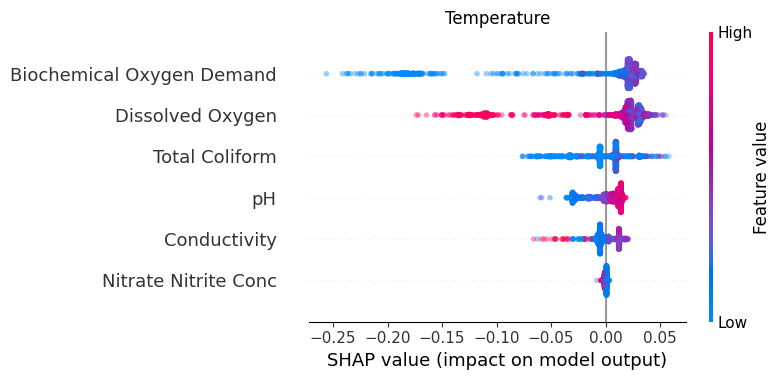

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


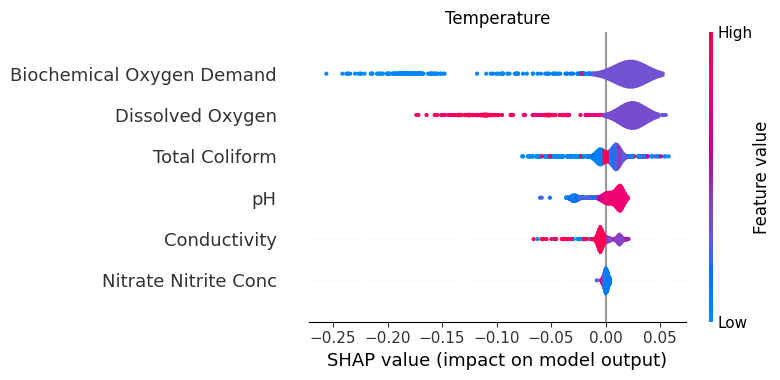

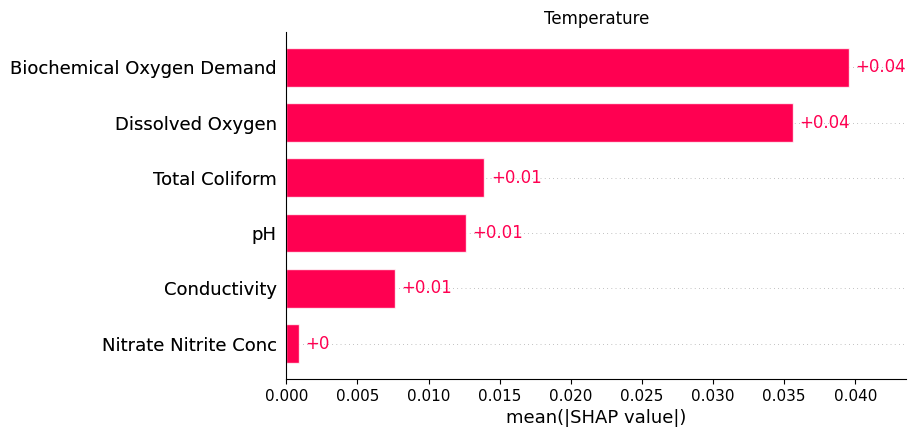

AB Dissolved Oxygen


Exact explainer: 1964it [15:08,  2.14it/s]                                                                                                                                                    
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


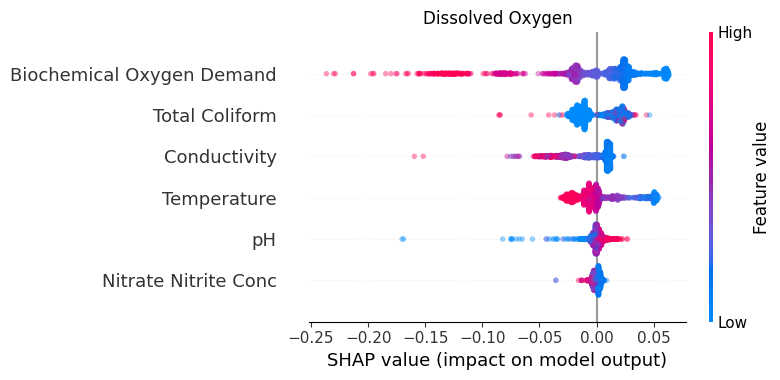

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


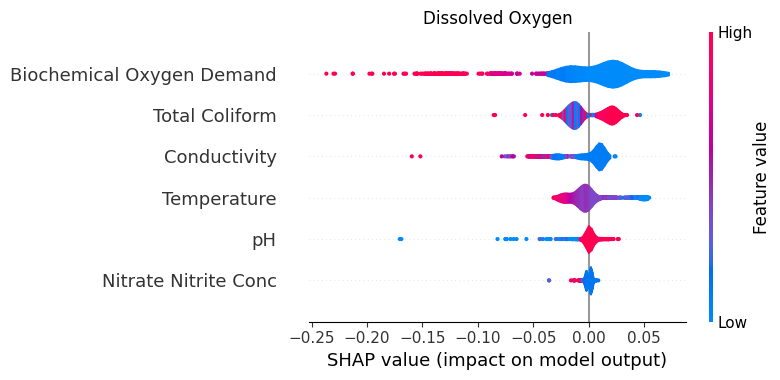

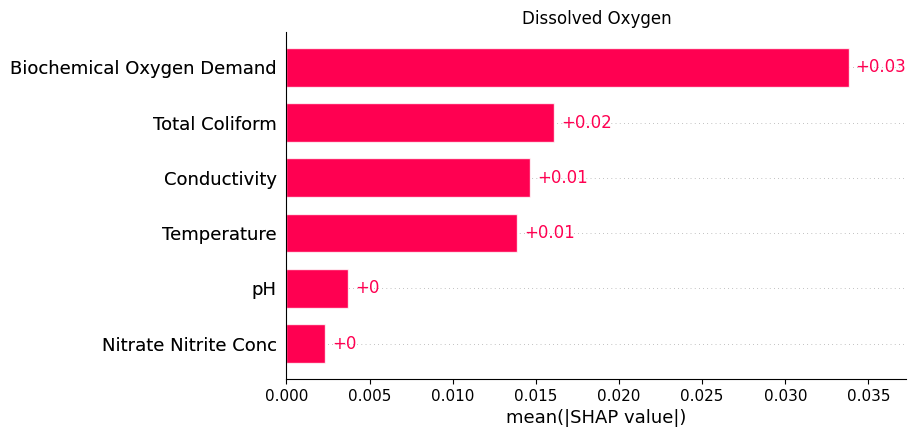

AB pH


Exact explainer: 1964it [15:30,  2.09it/s]                                                                                                                                                    
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


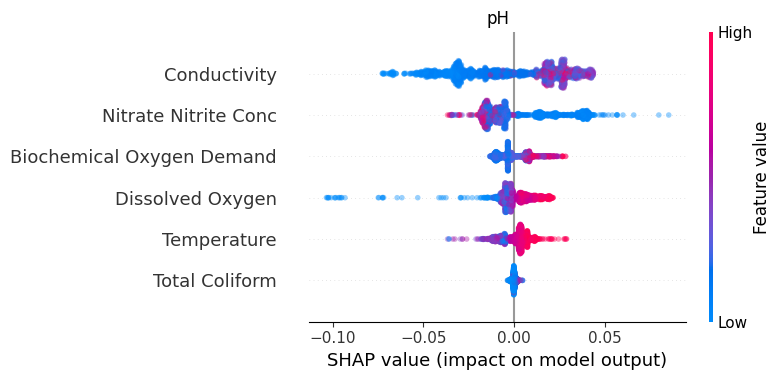

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


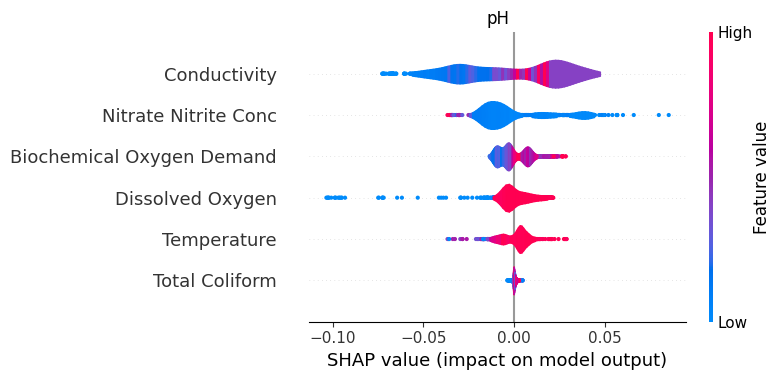

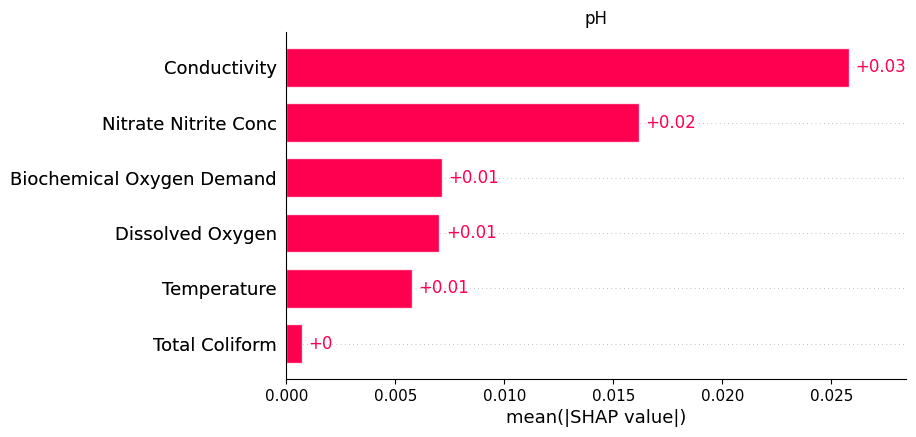

AB Conductivity


Exact explainer: 1964it [14:20,  2.25it/s]                                                                                                                                                    
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


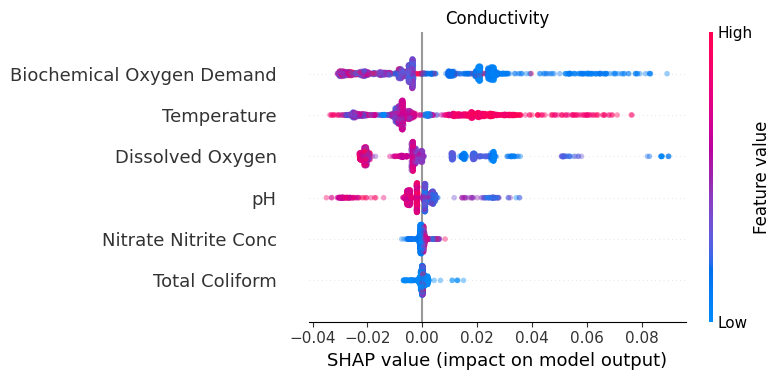

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


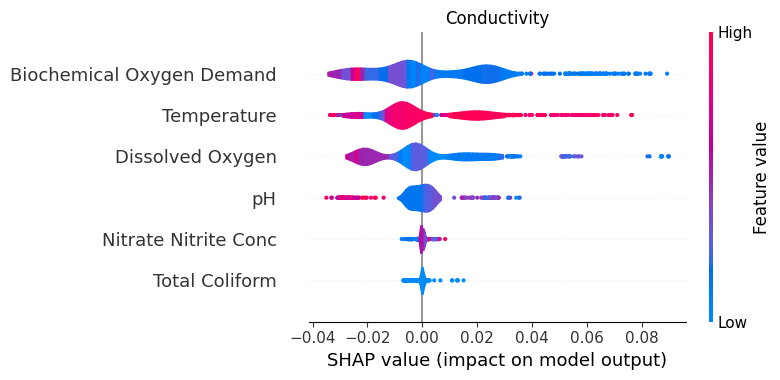

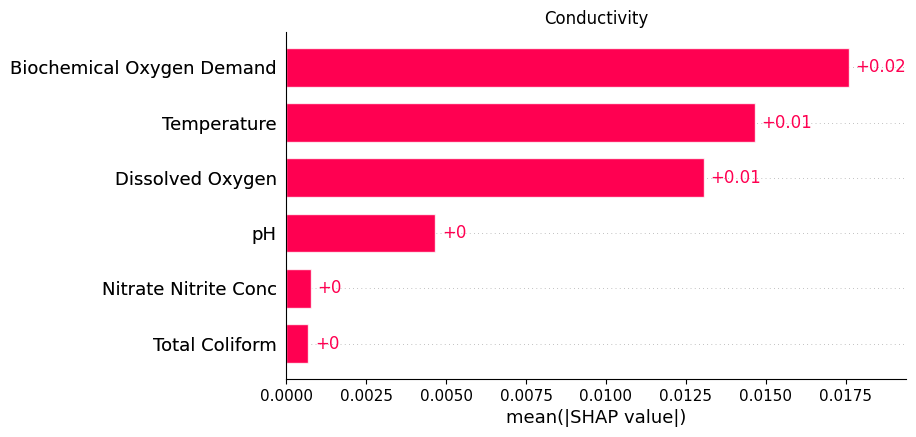

AB Biochemical Oxygen Demand


Exact explainer: 1964it [14:18,  2.26it/s]                                                                                                                                                    
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


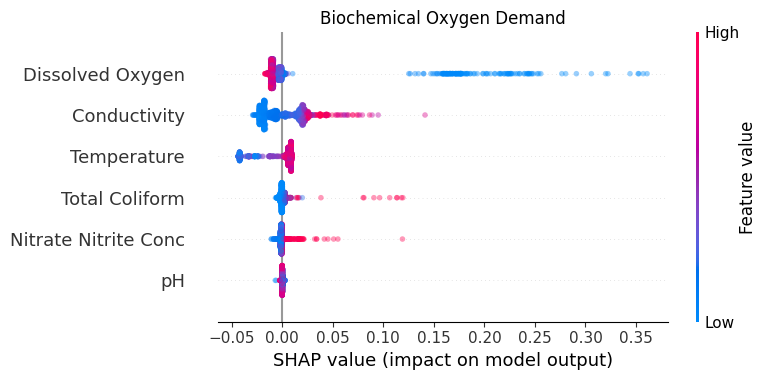

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


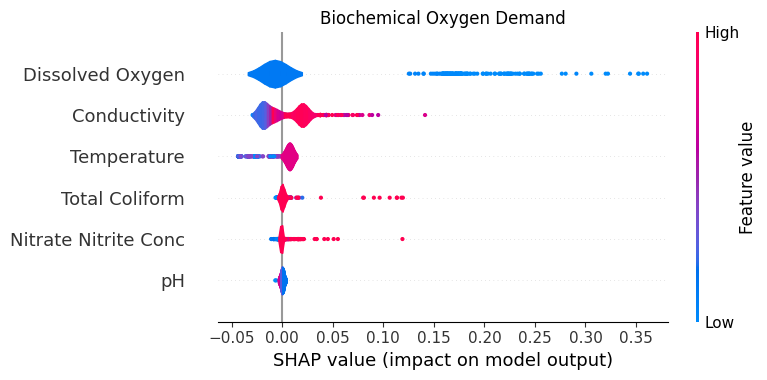

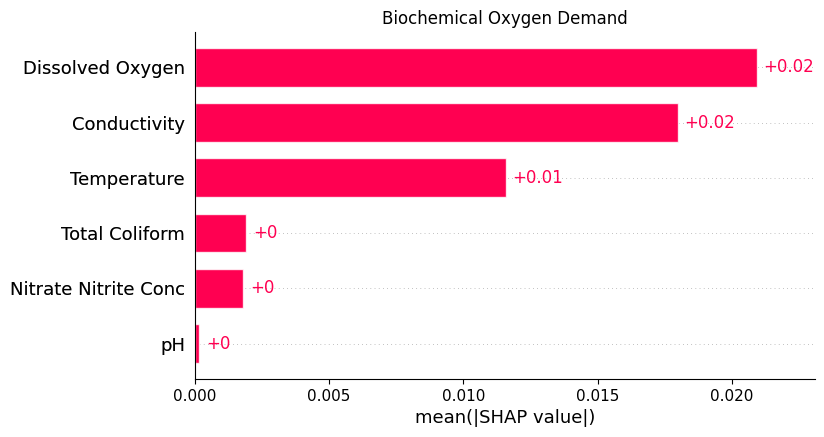

AB Nitrate Nitrite Conc


Exact explainer: 1964it [14:42,  2.20it/s]                                                                                                                                                    
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


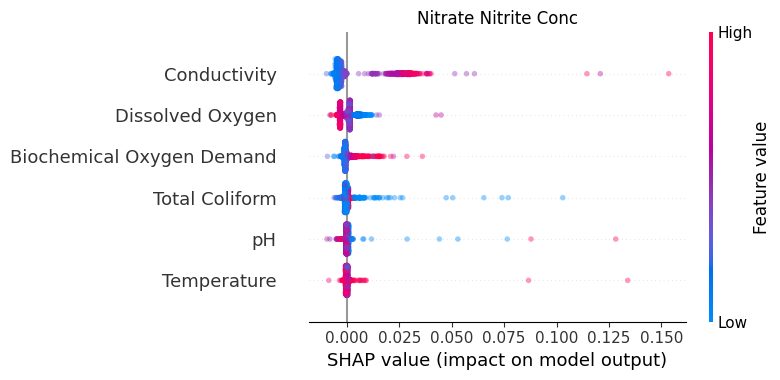

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


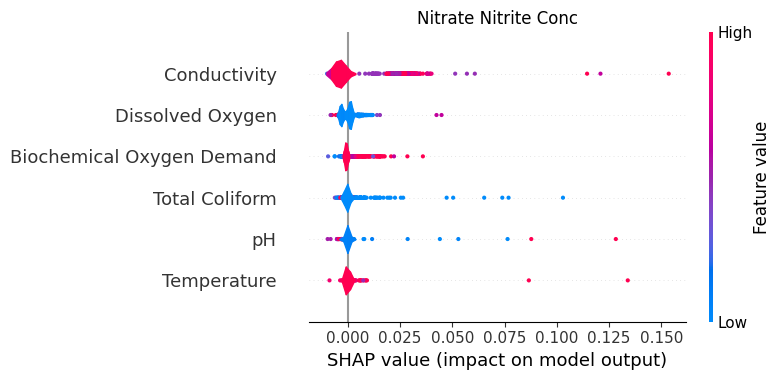

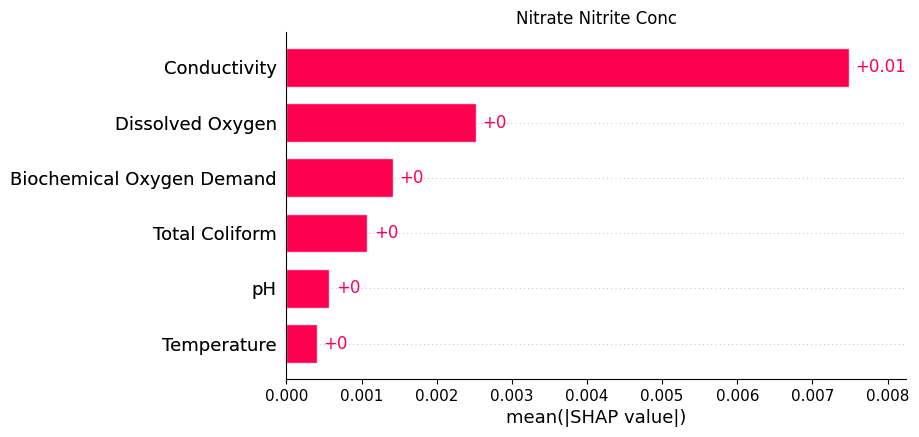

AB Total Coliform


Exact explainer: 1964it [12:09,  2.65it/s]                                                                                                                                                    
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


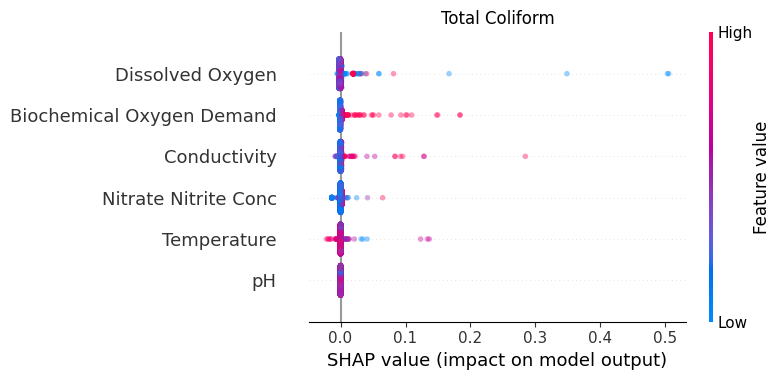

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


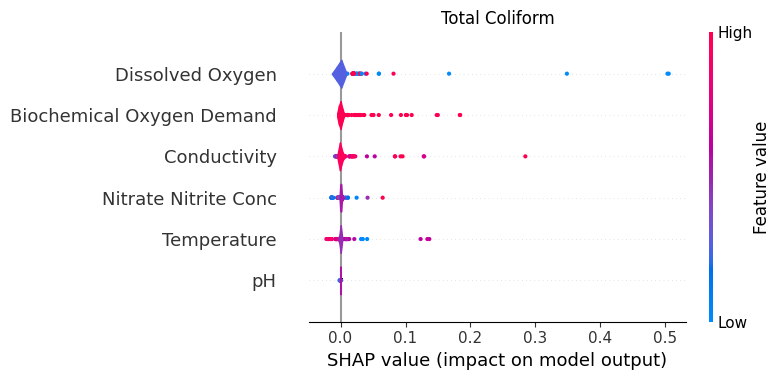

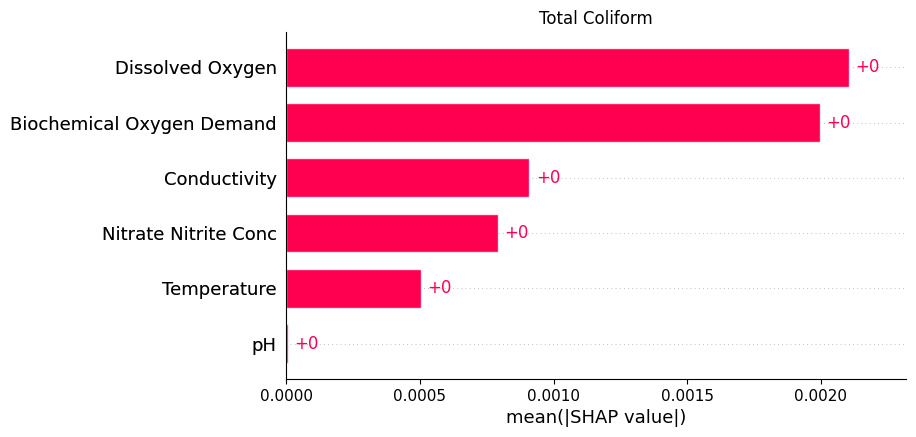

In [ ]:
for target_name in Parameters:
    if target_name is not Parameters.FC:
        shap_func(
            config={
                "model_name": Models.AB,
                "target": target_name,
                "exclude_features": exclude_features,
                "path_prefix": path_prefix,
            },
            train_df=train_df,
            save_plot=True,
        )

In [ ]:
model_name = Models.RF
target = Parameters.TC

In [ ]:
targets = target
log = prettylog("Training")
models = {}

exclude_features = literal_to_list(exclude_features)
targets = literal_to_list(targets)
est = estimators[model_name]

finetuned = get_fineduned_hyperparams(
    model_name=model_name,
    estimator=est(**model_params[model_name]["fixed"]),
    hyperparam=model_params[model_name]["tuning"],
    sample_percent=1,
    train_df=train_df,
    targets=targets,
    exclude_features=exclude_features,
    path_prefix=path_prefix,
)

full_model_params = {}
for target, finetuned_hp in finetuned.items():
    full_model_params[target] = concat_dicts(
        model_params[model_name]["fixed"],
        finetuned_hp,
        model_params[model_name]["other"],
    )

num_targets = full_model_params.keys().__len__()
for index, (target, parameters) in (
    pbar := tqdm.tqdm(
        enumerate(full_model_params.items()),
        desc="",
        bar_format="{desc}",
    )
):
    pbar.set_description_str(
        f"Training for {target}. Progress: {index + 1}/{num_targets}"
    )

    reg = est(**parameters)

    if model_name == Models.XGB:
        X_train, X_eval, y_train, y_eval = get_train_data(
            df=train_df,
            target=target,
            validation_split=0.2,
            exclude_features=exclude_features,
        )
        reg.fit(X_train, y_train, eval_set=[(X_eval, y_eval)], verbose=0)
    else:
        X_train, y_train = get_train_data(
            df=train_df, target=target, exclude_features=exclude_features
        )
        reg.fit(X_train, y_train)

    models[target] = reg

[Hyperparameter tuning]: Reading from cache...
[<Parameters.TC: 'Total Coliform'>]


Training for Total Coliform. Progress: 1/1


In [ ]:
models[target]

RandomForestRegressor(max_depth=10, max_samples=0.5, n_estimators=1000,
                      random_state=0)

In [ ]:
X_train, *_ = get_train_data(
    df=train_df,
    target=target,
    # validation_split=0.2 if model_name == Models.XGB else None,
    exclude_features=exclude_features,
)
# model = load_models(model_name, target, path_prefix)[target]
model = models[target]

explainer = shap.TreeExplainer(model, X_train)
shap_value = explainer(X_train, check_additivity=False)

 99%|===================| 1951/1963 [02:00<00:00]        

In [ ]:
write_pkl(
    shap_value,
    all_paths["shap_value"]
    .joinpath(path_prefix, model_name, target)
    .with_suffix(".pkl"),
)